# Analysis of Rainfall in Sydney

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import sklearn.linear_model
import math
import numpy

IDCJAC0009 is rainfall. Station 066062 is the Sydney observatory. You can download the zipfiles from
the Bureau of Meteorology's long-term data pages -- http://www.bom.gov.au/climate/data/

In [2]:
rainfall_measurement_code = 'IDCJAC0009_066062_1800'

In [3]:
def season(month):
    if month in [12,1,2]: return 'summer'
    if month in [3,4,5]: return 'autumn'
    if month in [6,7,8]: return 'winter'
    if month in [9,10,11]: return 'spring'
    
def binary_season(month):
    if month in [10,11,12,1,2,3]: return 'hot-season'
    return 'cold-season'

In [4]:
rainfall_zip = zipfile.ZipFile(rainfall_measurement_code + '.zip')
rainfall_zip.extract(rainfall_measurement_code + '_Data.csv')
rainfall = pd.read_csv(rainfall_measurement_code + '_Data.csv', parse_dates=[['Year','Month','Day']])
rainfall['Year'] = rainfall.Year_Month_Day.dt.year
rainfall['Season'] = rainfall.Year_Month_Day.dt.month.map(season)
rainfall['Binary_Season'] = rainfall.Year_Month_Day.dt.month.map(binary_season)
rainfall.set_index('Year_Month_Day', inplace=True)
rainfall.columns = ['code', 'station', 'rainfall_amount', 'measurement_period', 'quality', 'year', 'season','binary_season']
rainfall.sample(10)

,code,station,rainfall_amount,measurement_period,quality,year,season,binary_season
Year_Month_Day,,,,,,,,
1877-12-28,IDCJAC0009,66062,0.0,NaN,Y,1877,summer,hot-season
2007-06-25,IDCJAC0009,66062,16.4,1.0,Y,2007,winter,cold-season
1970-06-11,IDCJAC0009,66062,0.0,NaN,Y,1970,winter,cold-season
1936-05-20,IDCJAC0009,66062,0.3,1.0,Y,1936,autumn,cold-season
1914-09-24,IDCJAC0009,66062,0.0,NaN,Y,1914,spring,cold-season
1897-04-16,IDCJAC0009,66062,0.0,NaN,Y,1897,autumn,cold-season
1882-12-17,IDCJAC0009,66062,2.3,1.0,Y,1882,summer,hot-season
1928-05-14,IDCJAC0009,66062,0.0,NaN,Y,1928,autumn,cold-season
1990-10-01,IDCJAC0009,66062,0.2,1.0,Y,1990,spring,hot-season


In [5]:
rainfall.loc[[rainfall.rainfall_amount.idxmax()]]

,code,station,rainfall_amount,measurement_period,quality,year,season,binary_season
Year_Month_Day,,,,,,,,
1986-08-06,IDCJAC0009,66062,327.6,1.0,Y,1986,winter,cold-season


A few oddities with the Sydney data, 26th April 2008 has a measurement period of 2.

In [6]:
rainfall[rainfall.measurement_period == 2]

,code,station,rainfall_amount,measurement_period,quality,year,season,binary_season
Year_Month_Day,,,,,,,,
2008-04-26,IDCJAC0009,66062,0.4,2.0,N,2008,autumn,cold-season


There is nothing particularly interesting the day before or the day after. I can't make
sense of this, so I assume that it's supposed to be 1.

In [7]:
rainfall.loc['2008-04-25': '2008-04-27']

,code,station,rainfall_amount,measurement_period,quality,year,season,binary_season
Year_Month_Day,,,,,,,,
2008-04-25,IDCJAC0009,66062,5.4,1.0,N,2008,autumn,cold-season
2008-04-26,IDCJAC0009,66062,0.4,2.0,N,2008,autumn,cold-season
2008-04-27,IDCJAC0009,66062,0.0,1.0,N,2008,autumn,cold-season


And on April 1st 2010, 0.2mm of rain fell, but it wasn't measured. I guess that's the
Bureau of Meteorology's April Fool's joke on us.

In [8]:
rainfall[rainfall.measurement_period.isnull() & (rainfall.rainfall_amount > 0)]

,code,station,rainfall_amount,measurement_period,quality,year,season,binary_season
Year_Month_Day,,,,,,,,
2010-04-01,IDCJAC0009,66062,0.2,NaN,N,2010,autumn,cold-season


So, I'm just ignoring the measurement period.

I'm not sure what it means when the rainfall_amount is null. Perhaps it means it wasn't measured?

In [9]:
rainfall[rainfall.rainfall_amount.isnull()].sample(5)

,code,station,rainfall_amount,measurement_period,quality,year,season,binary_season
Year_Month_Day,,,,,,,,
1858-03-16,IDCJAC0009,66062,NaN,NaN,NaN,1858,autumn,hot-season
1858-03-06,IDCJAC0009,66062,NaN,NaN,NaN,1858,autumn,hot-season
1858-01-20,IDCJAC0009,66062,NaN,NaN,NaN,1858,summer,hot-season
1858-06-11,IDCJAC0009,66062,NaN,NaN,NaN,1858,winter,cold-season
1858-01-11,IDCJAC0009,66062,NaN,NaN,NaN,1858,summer,hot-season


## Total Rainfall

Text(0.5, 1.0, 'Number of mm of rain in the cold season')

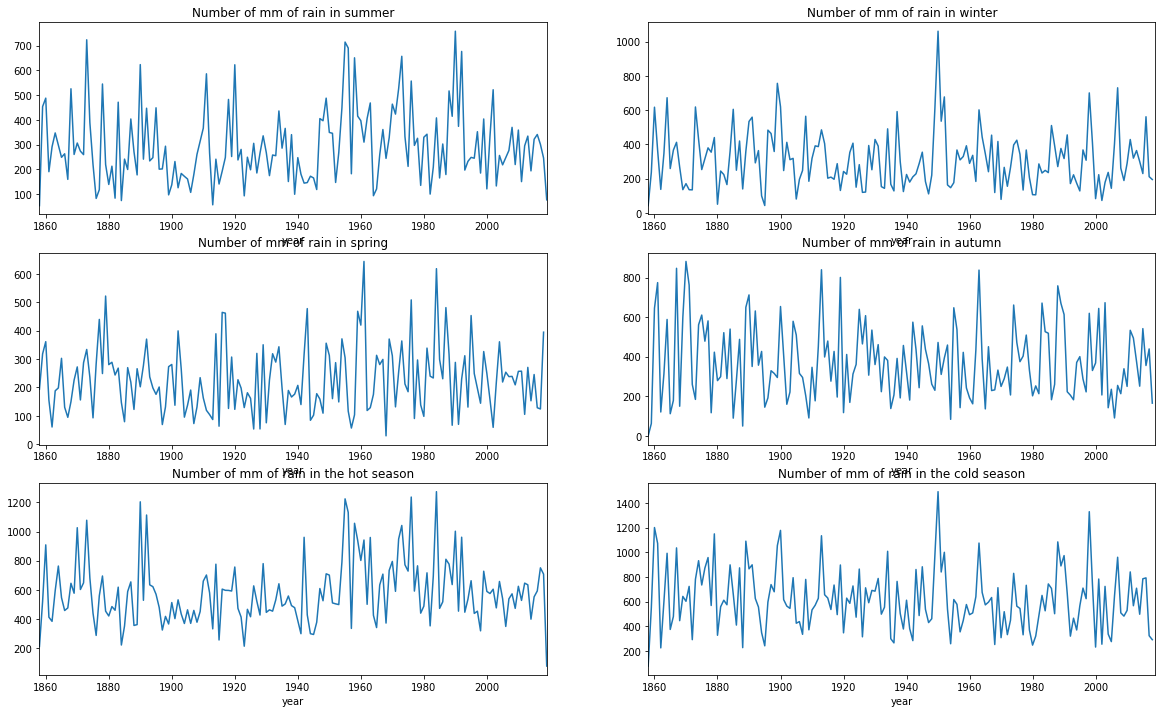

In [10]:
seasonal_rain_qty = pd.DataFrame({
    'summer' : rainfall[(rainfall.season == 'summer')].groupby(['year']).rainfall_amount.sum(),
    'winter' : rainfall[(rainfall.season == 'winter')].groupby(['year']).rainfall_amount.sum(),
    'spring' : rainfall[(rainfall.season == 'spring')].groupby(['year']).rainfall_amount.sum(),
    'autumn' : rainfall[(rainfall.season == 'autumn')].groupby(['year']).rainfall_amount.sum(),
    'hotseason' : rainfall[(rainfall.binary_season == 'hot-season')].groupby(['year']).rainfall_amount.sum(),
    'coldseason' : rainfall[(rainfall.binary_season == 'cold-season')].groupby(['year']).rainfall_amount.sum(),

})
(fig,ax) = plt.subplots(3,2, figsize=(20,12))
seasonal_rain_qty.summer.plot(ax=ax[0][0])
seasonal_rain_qty.winter.plot(ax=ax[0][1])
ax[0][0].set_title("Number of mm of rain in summer")
ax[0][1].set_title("Number of mm of rain in winter")
seasonal_rain_qty.spring.plot(ax=ax[1][0])
seasonal_rain_qty.autumn.plot(ax=ax[1][1])
ax[1][0].set_title("Number of mm of rain in spring")
ax[1][1].set_title("Number of mm of rain in autumn")
seasonal_rain_qty.hotseason.plot(ax=ax[2][0])
seasonal_rain_qty.coldseason.plot(ax=ax[2][1])
ax[2][0].set_title("Number of mm of rain in the hot season")
ax[2][1].set_title("Number of mm of rain in the cold season")



It's not obvious what's going on here. Let's do a rolling average over half-centuries where it becomes
really, really clear...

Text(0.5, 1.0, 'Number of mm of rain in the cold season (smoothed)')

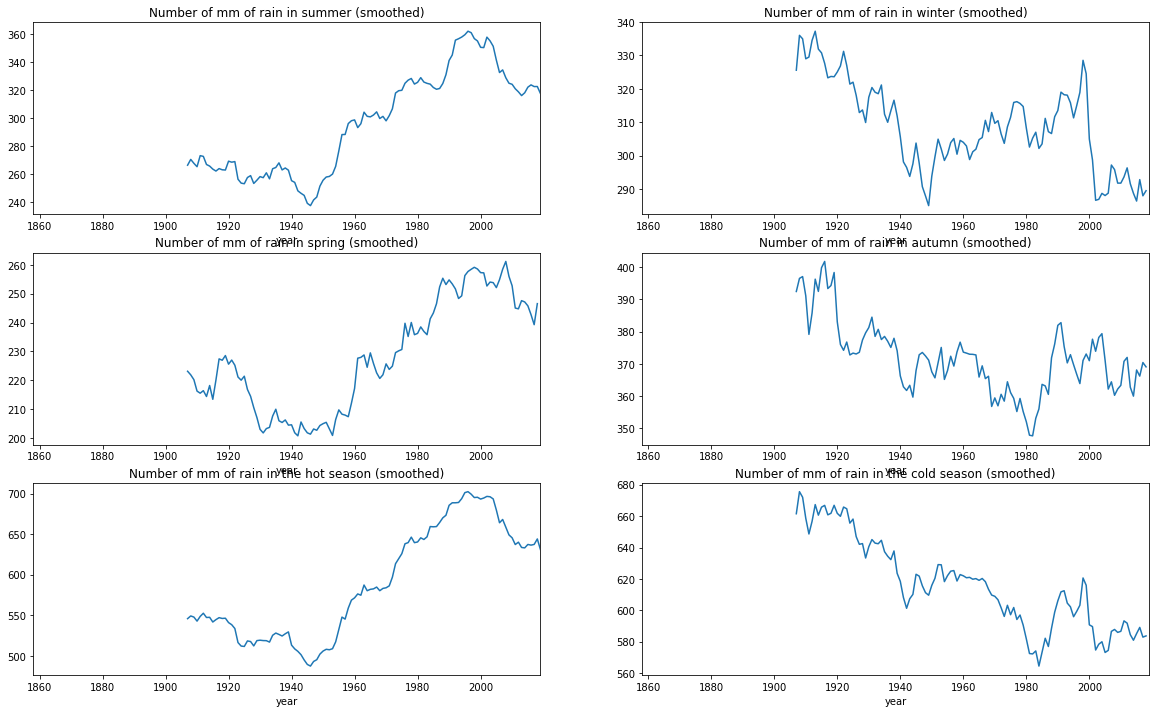

In [11]:
(fig,ax) = plt.subplots(3,2, figsize=(20,12))
seasonal_rain_qty.summer.rolling(50).mean().plot(ax=ax[0][0])
seasonal_rain_qty.winter.rolling(50).mean().plot(ax=ax[0][1])
ax[0][0].set_title("Number of mm of rain in summer (smoothed)")
ax[0][1].set_title("Number of mm of rain in winter (smoothed)")
seasonal_rain_qty.spring.rolling(50).mean().plot(ax=ax[1][0])
seasonal_rain_qty.autumn.rolling(50).mean().plot(ax=ax[1][1])
ax[1][0].set_title("Number of mm of rain in spring (smoothed)")
ax[1][1].set_title("Number of mm of rain in autumn (smoothed)")
seasonal_rain_qty.hotseason.rolling(50).mean().plot(ax=ax[2][0])
seasonal_rain_qty.coldseason.rolling(50).mean().plot(ax=ax[2][1])
ax[2][0].set_title("Number of mm of rain in the hot season (smoothed)")
ax[2][1].set_title("Number of mm of rain in the cold season (smoothed)")

More rain in the summer and spring, less in winter and autumn; more rain in the hot months, less in the cold months.

That trend is clear: but are we getting more rain overall?

Text(0, 0.5, 'mm of rain')

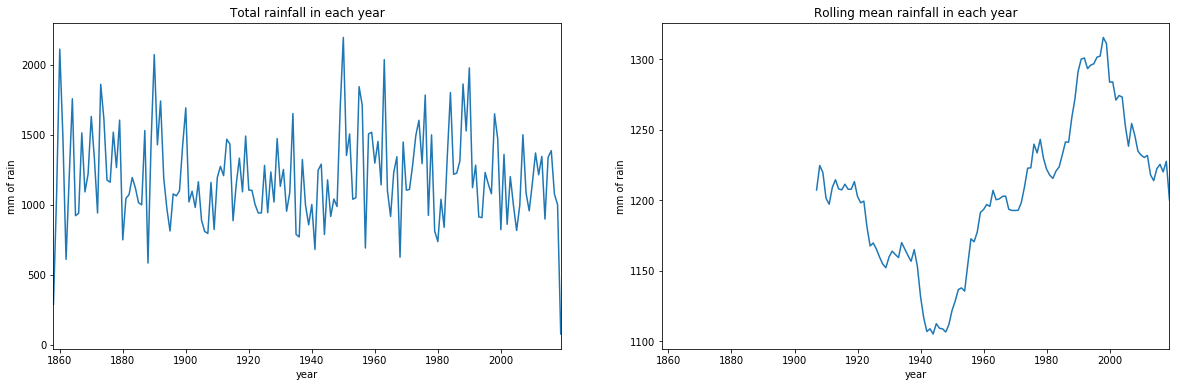

In [12]:
(fig,ax) = plt.subplots(1,2, figsize=(20,6))
rainfall.groupby('year').rainfall_amount.sum().plot(ax=ax[0])
ax[0].set_title("Total rainfall in each year")
ax[0].set_ylabel("mm of rain")
rainfall.groupby('year').rainfall_amount.sum().rolling(50).mean().plot(ax=ax[1])
ax[1].set_title("Rolling mean rainfall in each year")
ax[1].set_ylabel("mm of rain")

Maybe there's a trend in total rainfall there, or maybe there isn't. I have a theory about this that
requires a lot of number crunching.

In the meantime, can we get a measure of how much more rain in summer/spring/hotseason that we're getting?

There is a lot of noise, so this is definitely the time for robust regressors.

Theil-Sen seems to be performing better than most; but even so, the summer regression figure
jumps from 0.3mm to 0.45mm per year.

In [13]:
rain_qty_regressors = {}

def get_slope(estimator):
    return estimator.coef_[0]

for season in seasonal_rain_qty.columns:
    rain_qty_regressors[season] = sklearn.linear_model.TheilSenRegressor(random_state=0)
    r = rain_qty_regressors[season]
    data = seasonal_rain_qty[season]
    data = data[data.notnull()]
    year_stamps = pd.DataFrame({'year': data.index })
    r.fit(X=year_stamps, y=data)
    print (season, "increases by", get_slope(r), "(per year)")

summer increases by 0.31671735231177234 (per year)
winter increases by -0.21713181648295732 (per year)
spring increases by 0.13178414849329417 (per year)


/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  "".format(max_iter=max_iter), ConvergenceWarning)


autumn increases by -0.09594832528354291 (per year)
hotseason increases by 0.6780638245781717 (per year)
coldseason increases by -0.5896560578273542 (per year)


/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  "".format(max_iter=max_iter), ConvergenceWarning)


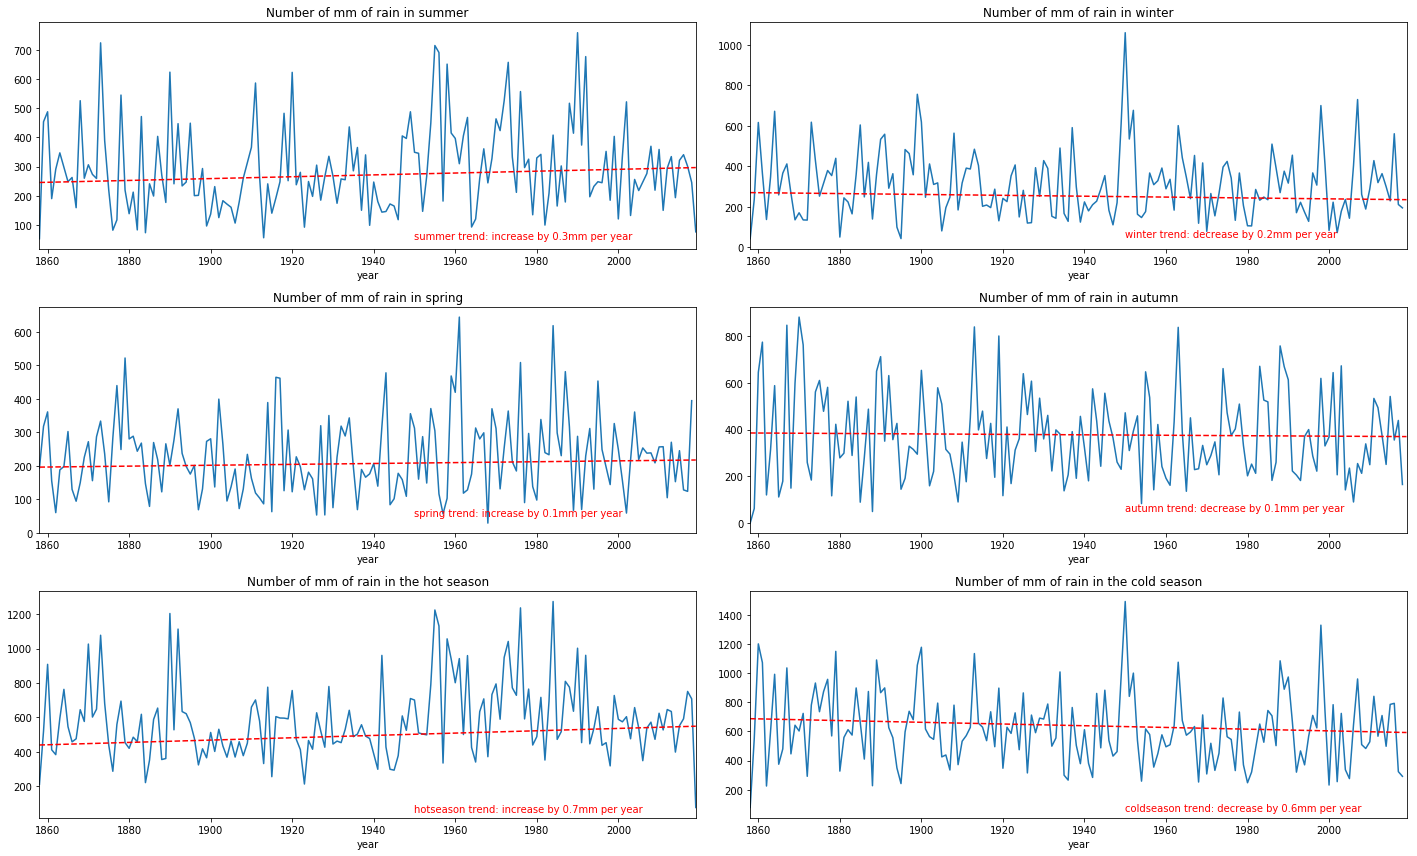

In [14]:
(fig,ax) = plt.subplots(3,2, figsize=(20,12))
start_year = seasonal_rain_qty.index.min()
end_year = seasonal_rain_qty.index.max()
line_coords = {}
trend_text = {}
for season in seasonal_rain_qty.columns:
    start_qty = rain_qty_regressors[season].predict([[start_year]])[0]
    end_qty = rain_qty_regressors[season].predict([[end_year]])[0]
    line_coords[season] = pd.Series(index=[start_year,end_year], data=[start_qty, end_qty])
    if get_slope(rain_qty_regressors[season]) > 0:
        trend_text[season] = "%s trend: increase by %.1fmm per year" % (season, get_slope(rain_qty_regressors[season]))
    else:
        trend_text[season] = "%s trend: decrease by %.1fmm per year" % (season, -get_slope(rain_qty_regressors[season]))
        
seasonal_rain_qty.summer.plot(ax=ax[0][0])
line_coords['summer'].plot(ax=ax[0][0], c="red", linestyle="--")
ax[0][0].annotate(trend_text['summer'], (1950, 50), color="red")
ax[0][0].set_title("Number of mm of rain in summer")

seasonal_rain_qty.winter.plot(ax=ax[0][1])
line_coords['winter'].plot(ax=ax[0][1], c="red", linestyle="--")
ax[0][1].annotate(trend_text['winter'], (1950, 50), color="red")
ax[0][1].set_title("Number of mm of rain in winter")

seasonal_rain_qty.spring.plot(ax=ax[1][0])
line_coords['spring'].plot(ax=ax[1][0], c="red", linestyle="--")
ax[1][0].annotate(trend_text['spring'], (1950, 50), color="red")
ax[1][0].set_title("Number of mm of rain in spring")

seasonal_rain_qty.autumn.plot(ax=ax[1][1])
line_coords['autumn'].plot(ax=ax[1][1], c="red", linestyle="--")
ax[1][1].annotate(trend_text['autumn'], (1950, 50), color="red")
ax[1][1].set_title("Number of mm of rain in autumn")

seasonal_rain_qty.hotseason.plot(ax=ax[2][0])
line_coords['hotseason'].plot(ax=ax[2][0], c="red", linestyle="--")
ax[2][0].annotate(trend_text['hotseason'], (1950, 50), color="red")
ax[2][0].set_title("Number of mm of rain in the hot season")

seasonal_rain_qty.coldseason.plot(ax=ax[2][1])
line_coords['coldseason'].plot(ax=ax[2][1], c="red", linestyle="--")
ax[2][1].annotate(trend_text['coldseason'], (1950, 50), color="red")
ax[2][1].set_title("Number of mm of rain in the cold season")
fig.tight_layout()

## What's going on?

Are storms getting heavier? Or more common?

In [15]:
seasonal_rain_typical = pd.DataFrame({
    'summer' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.season == 'summer')].groupby(['year']).rainfall_amount.median(),
    'winter' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.season == 'winter')].groupby(['year']).rainfall_amount.median(),
    'spring' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.season == 'spring')].groupby(['year']).rainfall_amount.median(),
    'autumn' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.season == 'autumn')].groupby(['year']).rainfall_amount.median(),
    'hotseason' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.binary_season == 'hot-season')].groupby(['year']).rainfall_amount.median(),
    'coldseason' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.binary_season == 'cold-season')].groupby(['year']).rainfall_amount.median(),
})

In [16]:
rain_typical_regressors = {}
for season in seasonal_rain_typical.columns:
    rain_typical_regressors[season] = sklearn.linear_model.TheilSenRegressor(random_state=0)
    r = rain_typical_regressors[season]
    data = seasonal_rain_typical[season]
    data = data[data.notnull()]
    year_stamps = pd.DataFrame({'year': data.index })
    r.fit(X=year_stamps, y=data)
    print (season, "increases by", get_slope(r), "(per year)")

summer increases by 0.0004116987769371371 (per year)
winter increases by 0.007025325397515668 (per year)
spring increases by 0.002820417881468878 (per year)
autumn increases by 0.005109701823153722 (per year)
hotseason increases by 0.0027787805373876537 (per year)
coldseason increases by 0.006437106752581557 (per year)


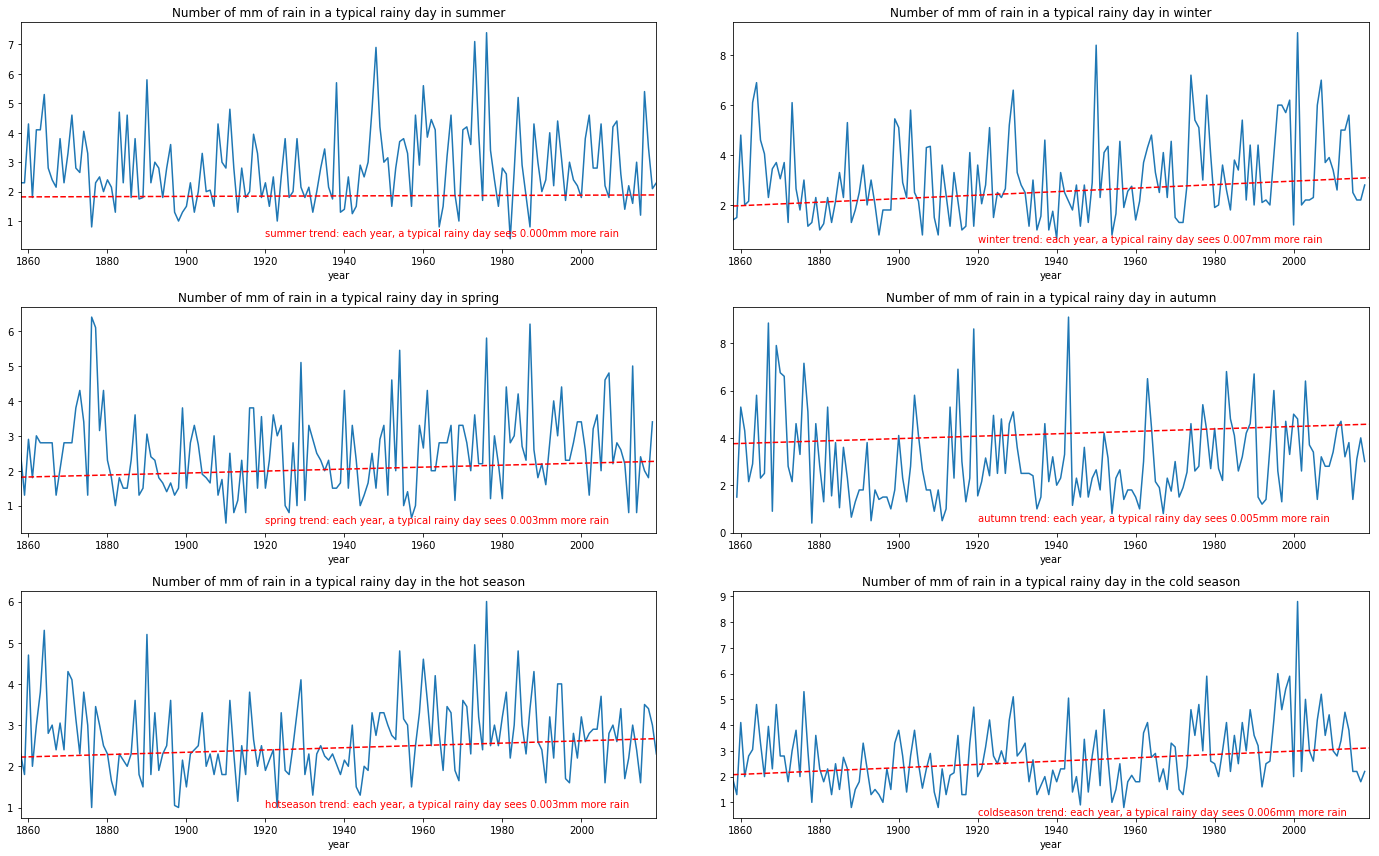

In [17]:
start_year = seasonal_rain_qty.index.min()
end_year = seasonal_rain_qty.index.max()
typical_line_coords = {}
typical_trend_text = {}
for season in seasonal_rain_qty.columns:
    start_qty = rain_typical_regressors[season].predict([[start_year]])[0]
    end_qty = rain_typical_regressors[season].predict([[end_year]])[0]
    typical_line_coords[season] = pd.Series(index=[start_year,end_year], data=[start_qty, end_qty])
    if get_slope(rain_typical_regressors[season]) > 0:
        typical_trend_text[season] = "%s trend: each year, a typical rainy day sees %.3fmm more rain" % (season, get_slope(rain_typical_regressors[season]))
    else:
        typical_trend_text[season] = "%s trend: each year, a typical rainy day sees %.3fmm less rain" % (season, -get_slope(rain_typical_regressors[season]))
        


(fig,ax) = plt.subplots(3,2, figsize=(20,12))

seasonal_rain_typical.summer.plot(ax=ax[0][0])
typical_line_coords['summer'].plot(ax=ax[0][0], c="red", linestyle="--")
ax[0][0].annotate(typical_trend_text['summer'], (1920, 0.5), color="red")
ax[0][0].set_title("Number of mm of rain in a typical rainy day in summer")

seasonal_rain_typical.winter.plot(ax=ax[0][1])
typical_line_coords['winter'].plot(ax=ax[0][1], c="red", linestyle="--")
ax[0][1].annotate(typical_trend_text['winter'], (1920, 0.5), color="red")
ax[0][1].set_title("Number of mm of rain in a typical rainy day in winter")

seasonal_rain_typical.spring.plot(ax=ax[1][0])
typical_line_coords['spring'].plot(ax=ax[1][0], c="red", linestyle="--")
ax[1][0].annotate(typical_trend_text['spring'], (1920, 0.5), color="red")
ax[1][0].set_title("Number of mm of rain in a typical rainy day in spring")

seasonal_rain_typical.autumn.plot(ax=ax[1][1])
typical_line_coords['autumn'].plot(ax=ax[1][1], c="red", linestyle="--")
ax[1][1].annotate(typical_trend_text['autumn'], (1920, 0.5), color="red")
ax[1][1].set_title("Number of mm of rain in a typical rainy day in autumn")

seasonal_rain_typical.hotseason.plot(ax=ax[2][0])
typical_line_coords['hotseason'].plot(ax=ax[2][0], c="red", linestyle="--")
ax[2][0].annotate(typical_trend_text['hotseason'], (1920, 1.0), color="red")
ax[2][0].set_title("Number of mm of rain in a typical rainy day in the hot season")

seasonal_rain_typical.coldseason.plot(ax=ax[2][1])
typical_line_coords['coldseason'].plot(ax=ax[2][1], c="red", linestyle="--")
ax[2][1].annotate(typical_trend_text['coldseason'], (1920, 0.5), color="red")
ax[2][1].set_title("Number of mm of rain in a typical rainy day in the cold season")
fig.tight_layout()

That's the *opposite* of what we'd expect. In winter and autumn (and cold times in general) the typical rainfall is growing. So it would have to be many fewer rainy days, even though each day is more intense.

What does the rolling 50 year trend look like?

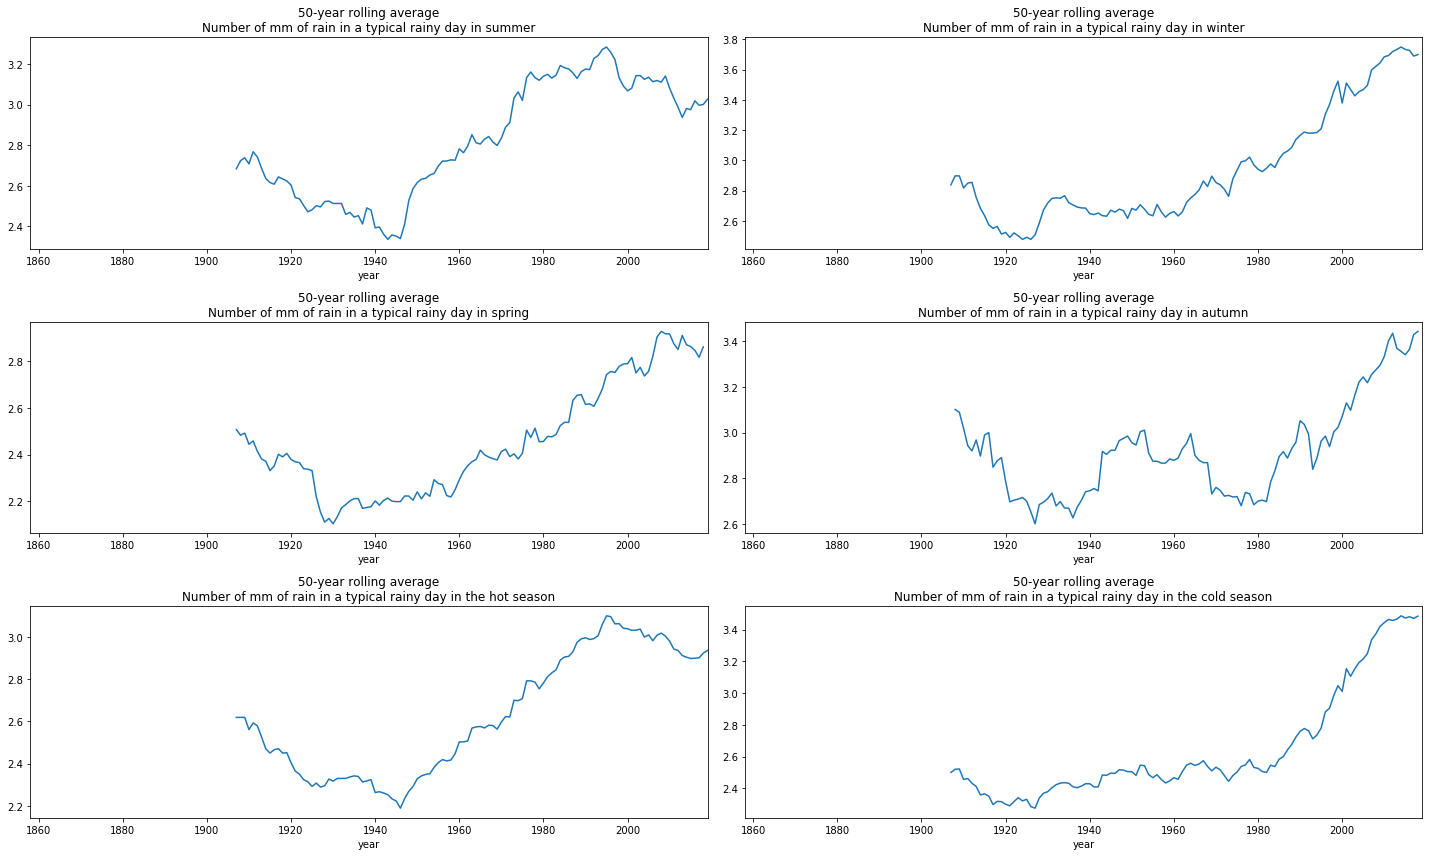

In [18]:
(fig,ax) = plt.subplots(3,2, figsize=(20,12))

seasonal_rain_typical.summer.rolling(50).mean().plot(ax=ax[0][0])
ax[0][0].set_title("50-year rolling average\nNumber of mm of rain in a typical rainy day in summer")

seasonal_rain_typical.winter.rolling(50).mean().plot(ax=ax[0][1])
ax[0][1].set_title("50-year rolling average\nNumber of mm of rain in a typical rainy day in winter")

seasonal_rain_typical.spring.rolling(50).mean().plot(ax=ax[1][0])
ax[1][0].set_title("50-year rolling average\nNumber of mm of rain in a typical rainy day in spring")

seasonal_rain_typical.autumn.rolling(50).mean().plot(ax=ax[1][1])
ax[1][1].set_title("50-year rolling average\nNumber of mm of rain in a typical rainy day in autumn")

seasonal_rain_typical.hotseason.rolling(50).mean().plot(ax=ax[2][0])
ax[2][0].set_title("50-year rolling average\nNumber of mm of rain in a typical rainy day in the hot season")

seasonal_rain_typical.coldseason.rolling(50).mean().plot(ax=ax[2][1])
ax[2][1].set_title("50-year rolling average\nNumber of mm of rain in a typical rainy day in the cold season")
fig.tight_layout()

### Number of days of rain?

So is there any trend in the number of days of rain in each season?

In [19]:
seasonal_rain = pd.DataFrame({
    'summer' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.season == 'summer')].groupby(['year']).rainfall_amount.count(),
    'winter' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.season == 'winter')].groupby(['year']).rainfall_amount.count(),
    'spring' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.season == 'spring')].groupby(['year']).rainfall_amount.count(),
    'autumn' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.season == 'autumn')].groupby(['year']).rainfall_amount.count(),
    'hotseason' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.binary_season == 'hot-season')].groupby(['year']).rainfall_amount.count(),
    'coldseason' : rainfall[(rainfall.rainfall_amount > 0) & (rainfall.binary_season == 'cold-season')].groupby(['year']).rainfall_amount.count(),
})

In [20]:
rain_count_regressors = {}
for season in seasonal_rain.columns:
    rain_count_regressors[season] = sklearn.linear_model.TheilSenRegressor(random_state=0)
    r = rain_count_regressors[season]
    data = seasonal_rain[season]
    data = data[data.notnull()]
    year_stamps = pd.DataFrame({'year': data.index })
    r.fit(X=year_stamps, y=data)
    print (season, "increases by", get_slope(r), "(per year)")

summer increases by 3.7065290307108386e-08 (per year)
winter increases by -0.0358692550924485 (per year)
spring increases by -8.353748404732986e-07 (per year)
autumn increases by -0.0344888085093047 (per year)
hotseason increases by 0.018181360307149508 (per year)
coldseason increases by -0.09991585369157915 (per year)


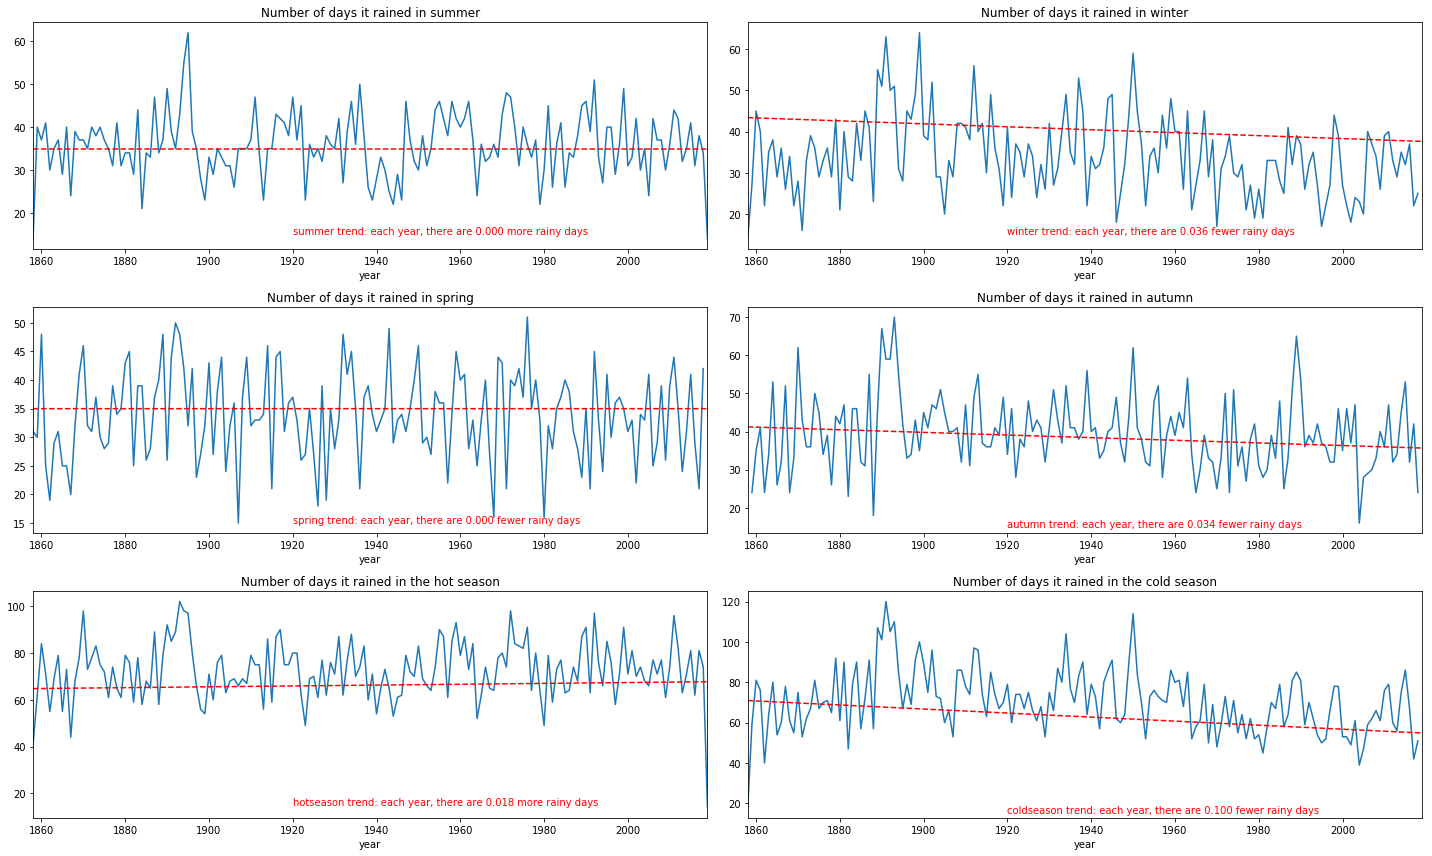

In [21]:
start_year = seasonal_rain_qty.index.min()
end_year = seasonal_rain_qty.index.max()
count_line_coords = {}
count_trend_text = {}
for season in seasonal_rain.columns:
    start_qty = rain_count_regressors[season].predict([[start_year]])[0]
    end_qty = rain_count_regressors[season].predict([[end_year]])[0]
    count_line_coords[season] = pd.Series(index=[start_year,end_year], data=[start_qty, end_qty])
    if get_slope(rain_count_regressors[season]) > 0:
        count_trend_text[season] = "%s trend: each year, there are %.3f more rainy days" % (season, get_slope(rain_count_regressors[season]))
    else:
        count_trend_text[season] = "%s trend: each year, there are %.3f fewer rainy days" % (season, -get_slope(rain_count_regressors[season]))
        

(fig,ax) = plt.subplots(3,2, figsize=(20,12))

seasonal_rain.summer.plot(ax=ax[0][0])
count_line_coords['summer'].plot(ax=ax[0][0], c="red", linestyle="--")
ax[0][0].annotate(count_trend_text['summer'], (1920, 15), color="red")
ax[0][0].set_title("Number of days it rained in summer")


seasonal_rain.winter.plot(ax=ax[0][1])
count_line_coords['winter'].plot(ax=ax[0][1], c="red", linestyle="--")
ax[0][1].annotate(count_trend_text['winter'], (1920, 15), color="red")
ax[0][1].set_title("Number of days it rained in winter")



seasonal_rain.spring.plot(ax=ax[1][0])
count_line_coords['spring'].plot(ax=ax[1][0], c="red", linestyle="--")
ax[1][0].annotate(count_trend_text['spring'], (1920, 15), color="red")
ax[1][0].set_title("Number of days it rained in spring")

seasonal_rain.autumn.plot(ax=ax[1][1])
count_line_coords['autumn'].plot(ax=ax[1][1], c="red", linestyle="--")
ax[1][1].annotate(count_trend_text['autumn'], (1920, 15), color="red")
ax[1][1].set_title("Number of days it rained in autumn")

seasonal_rain.hotseason.plot(ax=ax[2][0])
count_line_coords['hotseason'].plot(ax=ax[2][0], c="red", linestyle="--")
ax[2][0].annotate(count_trend_text['hotseason'], (1920, 15), color="red")
ax[2][0].set_title("Number of days it rained in the hot season")

seasonal_rain.coldseason.plot(ax=ax[2][1])
count_line_coords['coldseason'].plot(ax=ax[2][1], c="red", linestyle="--")
ax[2][1].annotate(count_trend_text['coldseason'], (1920, 15), color="red")
ax[2][1].set_title("Number of days it rained in the cold season")

fig.tight_layout()

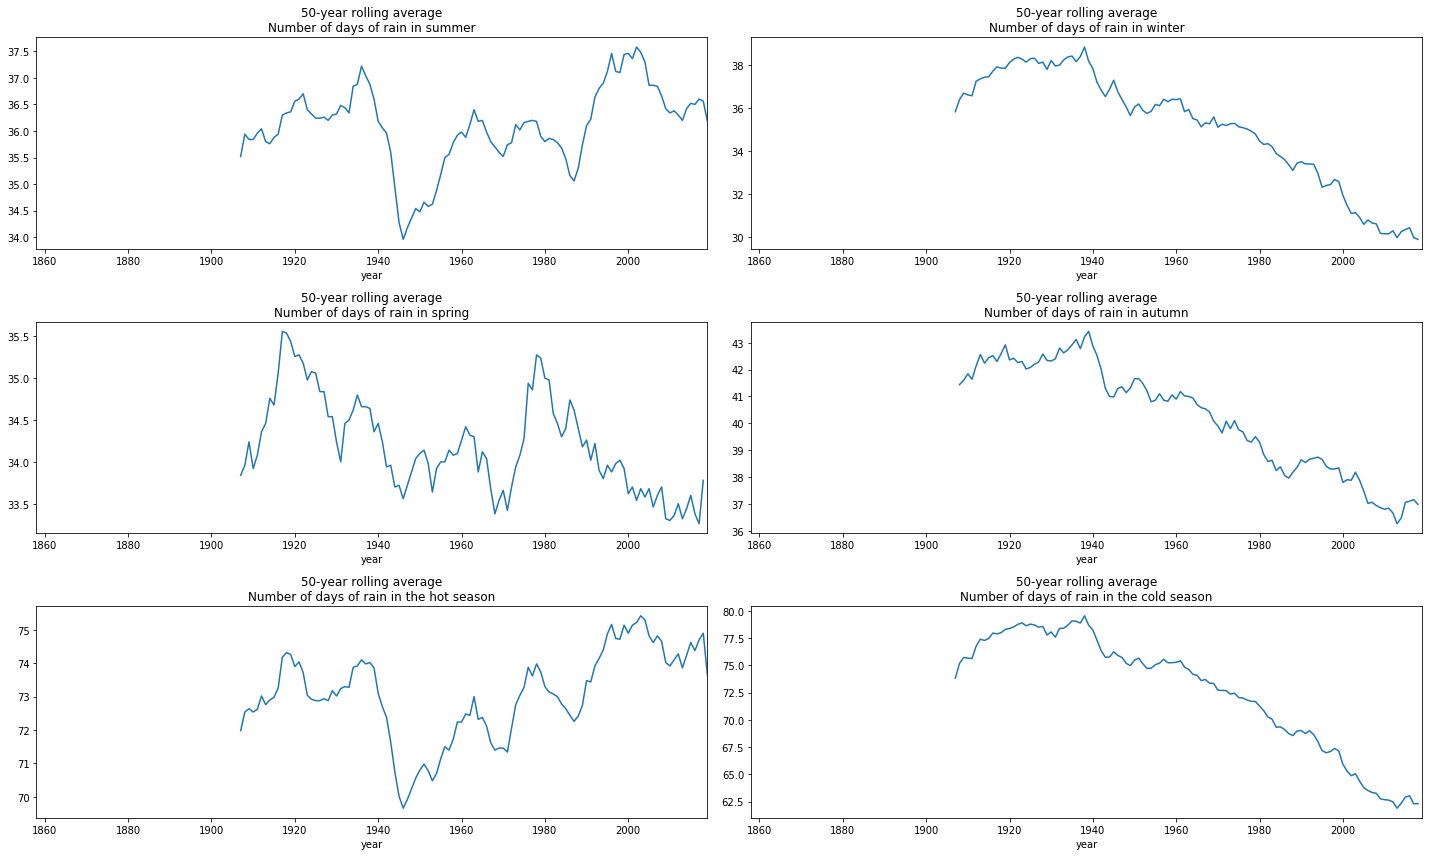

In [22]:
(fig,ax) = plt.subplots(3,2, figsize=(20,12))

seasonal_rain.summer.rolling(50).mean().plot(ax=ax[0][0])
ax[0][0].set_title("50-year rolling average\nNumber of days of rain in summer")

seasonal_rain.winter.rolling(50).mean().plot(ax=ax[0][1])
ax[0][1].set_title("50-year rolling average\nNumber of days of rain in winter")

seasonal_rain.spring.rolling(50).mean().plot(ax=ax[1][0])
ax[1][0].set_title("50-year rolling average\nNumber of days of rain in spring")

seasonal_rain.autumn.rolling(50).mean().plot(ax=ax[1][1])
ax[1][1].set_title("50-year rolling average\nNumber of days of rain in autumn")

seasonal_rain.hotseason.rolling(50).mean().plot(ax=ax[2][0])
ax[2][0].set_title("50-year rolling average\nNumber of days of rain in the hot season")

seasonal_rain.coldseason.rolling(50).mean().plot(ax=ax[2][1])
ax[2][1].set_title("50-year rolling average\nNumber of days of rain in the cold season")
fig.tight_layout()

## Analysis Summary

- In summer (and hot times in general), we are seeing more rain, but the typical rainy day drops no more rain now than     it did in 1860. Nor is it raining for more days. Are the top end of storms getting bigger? There is that funny pattern 
  starting arount 1950 though.

- Winter is definitely getting drier: fewer days of rain; far fewer than you need in order to make up for the 
  bigger storms.

# TL;DR

I call April - September the cold season. This is becoming less true than it used to be! I remember the "cold season" from my childhood having sport cancelled a little bit more regularly than it is for my children. By the way if anyone
else from my soccer team is reading this, do any of you remember us ever scoring a goal or winning a game? Maybe we
didn't practice enough.

Anyway, I don't remember the droughts being as bad back then either.

So how much less rain are we getting?

Looking at the left-hand graph, it's a very noisy signal, so I went with a Theil-Sen regressor to try to find a good
trend line. Theil-Sen should be more robust to noise than using ordinary least squares. It's not super-accurate, but roughly 0.6mm per year looks about right. 30mm difference since the 1960s is roughly 5% less rain.

Normally I wouldn't want to do a 50 year rolling average on a data set that only goes back to 1859, but anything
much less than that and the trend wasn't very clear. Even using a 50 year trend (the graph on the right) it's
still quite lumpy.

Text(0.5, 1.0, '50-year rolling average\nNumber of mm of rain in the cold season (smoothed)')

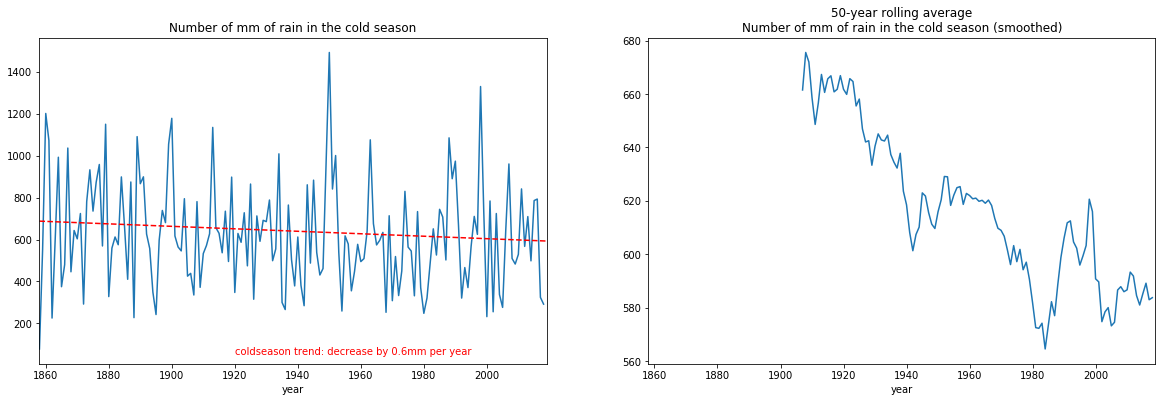

In [23]:
(fig,ax) = plt.subplots(1,2, figsize=(20,6))
seasonal_rain_qty.coldseason.plot(ax=ax[0])
line_coords['coldseason'].plot(ax=ax[0], c="red", linestyle="--")
ax[0].annotate(trend_text['coldseason'], (1920, 50), color="red")
ax[0].set_title("Number of mm of rain in the cold season")

seasonal_rain_qty.coldseason.rolling(50).mean().plot(ax=ax[1])
ax[1].set_title("50-year rolling average\nNumber of mm of rain in the cold season (smoothed)")

So what's going on? Is it raining less heavily than it used to?

Text(0.5, 1.0, '50-year rolling average\nNumber of mm of rain in a typical rainy day in the cold season')

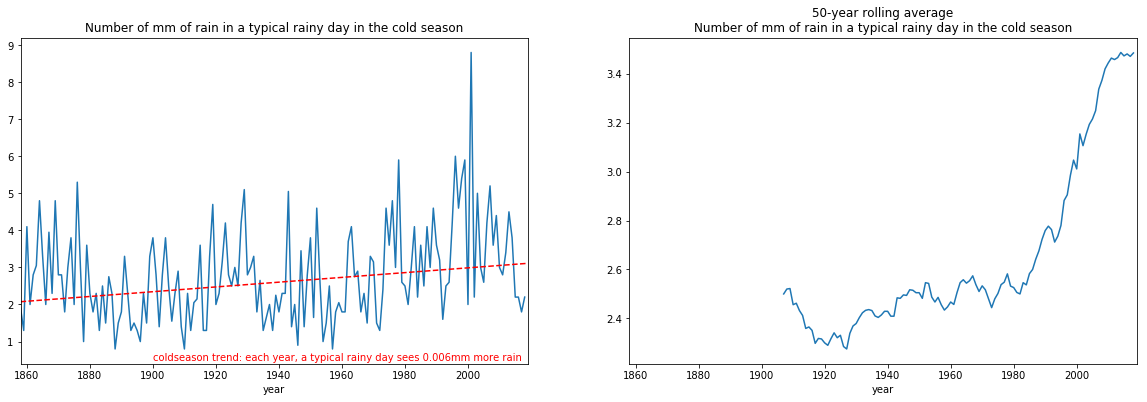

In [24]:
(fig, ax) = plt.subplots(1,2, figsize=(20,6))
seasonal_rain_typical.coldseason.plot(ax=ax[0])
typical_line_coords['coldseason'].plot(ax=ax[0], c="red", linestyle="--")
ax[0].annotate(typical_trend_text['coldseason'], (1900, 0.5), color="red")
ax[0].set_title("Number of mm of rain in a typical rainy day in the cold season")


seasonal_rain_typical.coldseason.rolling(50).mean().plot(ax=ax[1])
ax[1].set_title("50-year rolling average\nNumber of mm of rain in a typical rainy day in the cold season")

Nope -- that's the opposite of what we expected. When it rains in the cold months, it rains harder than it used to.

When it rains, it rains harder. In 2001, a typical cold-season storm dropped 8.8mm of rain. In 1901, a typical
storm dropped 2.8

In [25]:
seasonal_rain_typical.coldseason.idxmax(), seasonal_rain_typical.coldseason.max()

(2001, 8.8)

In [26]:
seasonal_rain_typical.coldseason[1901]

2.8

So is it raining less often?

Text(0.5, 1.0, '50-year rolling average\nNumber of days of rain in the cold season')

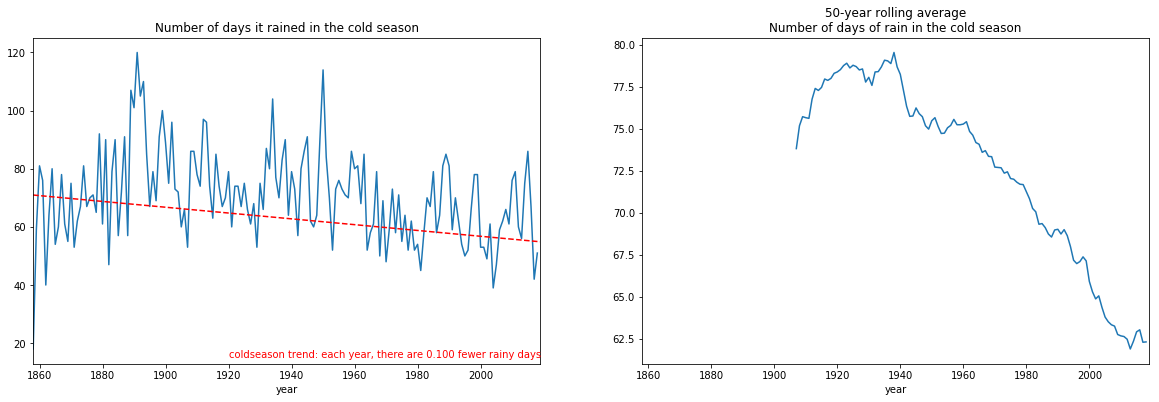

In [27]:
(fig, ax) = plt.subplots(1,2, figsize=(20,6))
seasonal_rain.coldseason.plot(ax=ax[0])
count_line_coords['coldseason'].plot(ax=ax[0], c="red", linestyle="--")
ax[0].annotate(count_trend_text['coldseason'], (1920, 15), color="red")
ax[0].set_title("Number of days it rained in the cold season")

seasonal_rain.coldseason.rolling(50).mean().plot(ax=ax[1])
ax[1].set_title("50-year rolling average\nNumber of days of rain in the cold season")

In [28]:
seasonal_rain.coldseason.idxmax(), seasonal_rain.coldseason.max()

(1891, 120.0)

In [29]:
seasonal_rain.coldseason.idxmin(), seasonal_rain.coldseason.min()

(1858, 18.0)

In [30]:
seasonal_rain.coldseason.nsmallest(12)

year
1858    18.0
2004    39.0
1862    40.0
2017    42.0
1981    45.0
1882    47.0
2005    47.0
1970    48.0
2002    49.0
1968    50.0
1995    50.0
2018    51.0
Name: coldseason, dtype: float64

Yep -- winter drought is a thing now. Back in 1891 it rained for 120 days (out of the 183 days in my "cold season").

Last year it was 50.

Out of the top 10 driest winters (fewest days of rain), 4 of them happened since 2000; and if we discount the extremely
dodgy-looking measurements from 1858 (the first year the Bureau was taking measurements) then 5 out of the top 10 occurred since 1995.

## Dryspell length?

In [31]:
in_drought = False
drought_start = None
drought_end = None
droughts = []
for date in rainfall.index:
    if rainfall.rainfall_amount[date] == 0:
        if in_drought:
            drought_end = date
            continue
        else:
            drought_start = date
            drought_end = date
            in_drought = True
            continue
    if in_drought:
        if drought_start != drought_end:
            droughts.append((drought_start, drought_end))
        in_drought = False
        continue
    # still in a rain streak
droughts = pd.DataFrame({
    'start' : [start for (start,end) in droughts],
    'end' : [end for (start,end) in droughts]
})
droughts['duration'] = droughts.end - droughts.start
droughts['duration_days'] = droughts.duration.dt.days
droughts['year'] = droughts.start.dt.year
droughts.sample(25)   

,start,end,duration,duration_days,year
2014,1906-02-26,1906-02-27,1 days,1,1906
1611,1896-09-10,1896-09-11,1 days,1,1896
4643,1969-09-07,1969-09-08,1 days,1,1969
420,1868-04-05,1868-04-07,2 days,2,1868
6321,2010-10-21,2010-10-23,2 days,2,2010
2769,1924-09-16,1924-09-21,5 days,5,1924
4237,1959-10-11,1959-10-12,1 days,1,1959
1680,1898-04-16,1898-04-17,1 days,1,1898
2795,1925-03-24,1925-03-27,3 days,3,1925
5314,1985-11-10,1985-11-12,2 days,2,1985


In [32]:
longest_drought_by_year = droughts.groupby('year').duration_days.max()

In [33]:
drought_regression = sklearn.linear_model.TheilSenRegressor()
drought_regression.fit(X=pd.DataFrame({'duration': longest_drought_by_year.index}), y=longest_drought_by_year)
drought_regression.coef_[0]

0.01885180252389429

Text(1960, 7, 'Each year, expect a drought 0.019 days longer than the previous year')

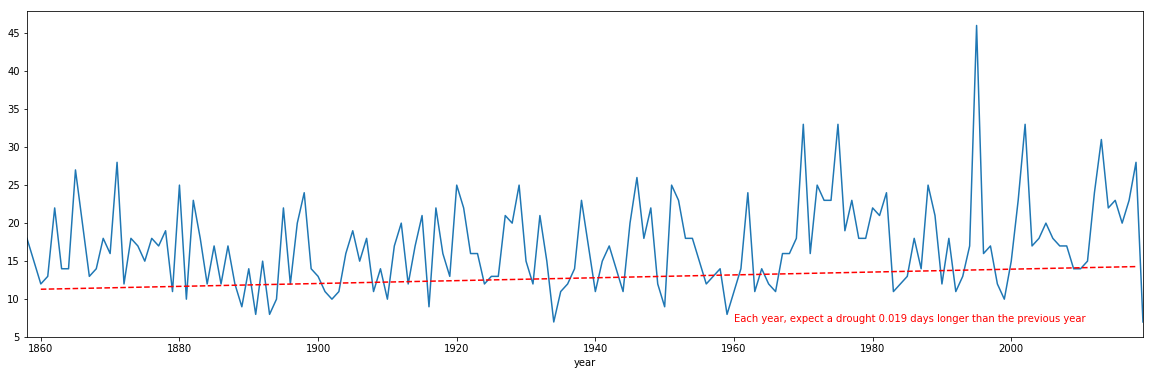

In [34]:
(fig,ax) = plt.subplots(1,1, figsize=(20,6))
longest_drought_by_year.plot(ax=ax)
[y1860, y2018] = drought_regression.predict([[1860],[2018]])
drought_line = pd.Series(index=[1860,2018], data=[y1860, y2018])
drought_line.plot(ax=ax, c="red", linestyle="--")
ax.annotate("Each year, expect a drought %.3f days longer than the previous year" % (drought_regression.coef_[0],),
            (1960,7), color="red")